In [1]:
!which python

/lfs/hyperturing1/0/kaif/miniforge/envs/sc/bin/python


In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,6,7,8"

from vllm import LLM, SamplingParams
from dataset import load_datasets, BOXED_ANSWERS_DATASETS, get_boxed_answer
from latex_formater import latex_deformat
from prompt import generate_nshot_prompts

In [5]:
??SamplingParams

In [ ]:
sampling_params = SamplingParams(temperature=0.8, top_p=0.95, max_tokens=1028)
# model_name = "deepseek-ai/deepseek-math-7b-instruct"
model_name = "llm-agents/tora-13b-v1.0"
llm = LLM(model=model_name, trust_remote_code=True, tensor_parallel_size=4, dtype="float16")

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

WARNING 02-28 22:10:59 config.py:577] Casting torch.bfloat16 to torch.float16.
INFO 02-28 22:10:59 config.py:413] Custom all-reduce kernels are temporarily disabled due to stability issues. We will re-enable them once the issues are resolved.


2024-02-28 22:10:59,372	INFO worker.py:1558 -- Calling ray.init() again after it has already been called.


In [4]:
%%capture
datasets = load_datasets(BOXED_ANSWERS_DATASETS);

A board game spinner is divided into three parts labeled $A$, $B$  and $C$.
The probability of the spinner landing on $A$ is $\\frac{1}{3}$ and the
probability of the spinner landing on $B$ is $\\frac{5}{12}$.  What is
the probability of the spinner landing on $C$? Express your answer as a
common fraction.

Solution: The spinner is guaranteed to land on exactly one of the three
regions, so we know that the sum of the probabilities of it landing in
each region will be 1. If we let the probability of it landing in region
$C$ be $x$, we then have the equation $1 = \\frac{5}{12}+\\frac{1}{3}+x$,
from which we have $x=\\boxed{\\frac{1}{4}}$.

Above is a question and correct solution. Propose a place in the solution
where a normal student might make a reasoning mistake. Then explain the
error beginning with "Explanation:".
~~
The student might make a mistake when summing the probabilities, and more
specifically when making the conversion between fractions and whole numbers.

Explanation: A common error might involve not correctly accounting for the
total probability being 1. For instance, the student might disregard the
conversion between different types of fractions. In this case, the student
may add the fractions incorrectly, perhaps adding $\frac{1}{3}$ and
$\frac{5}{12}$ as if they are like fractions, resulting in a incorrect sum
of $\frac{6}{15}$ instead of the correct sum $\frac{13}{12}$, and
subsequently derive an incorrect value for $x$. 
~~
Now construct the students complete response that makes this mistake. Do
NOT point out the mistake in the response. Adhere to the original
formatting. Begin with "Solution:".
~~
Solution: The spinner is guaranteed to land on exactly one of the three
regions, so we know that the sum of the probabilities of it landing in
each region will be 1. If we let the probability of it landing in region
$C$ be $x$, we then have the equation $1 = \frac{5}{12}+\frac{1}{3}+x$. 

When adding the fractions $\frac{5}{12}$ and $\frac{1}{3}$ directly, we
get $\frac{6}{15}$. Subtracting this from 1 gives us $1 - \frac{6}{15}
= \frac{9}{15}$, which simplifies to $x = \boxed{\frac{3}{5}}$.

In [6]:
DATASET_MAP = {
    'EleutherAI/hendrycks_math_algebra': 'Algebra',
    'EleutherAI/hendrycks_math_counting_and_probability': 'Counting and Probability',
    'EleutherAI/hendrycks_math_geometry': 'Geometry',
    'EleutherAI/hendrycks_math_intermediate_algebra': 'Intermediate Algebra',
    'EleutherAI/hendrycks_math_number_theory': 'Number Theory',
    'EleutherAI/hendrycks_math_prealgebra': 'Prealgebra',
    'EleutherAI/hendrycks_math_precalculus': 'Precalculus',
    'gsm8k_main': 'GSM8K'
}

MODEL_MAP = {
    'deepseek-ai/deepseek-math-7b-rl': 'Deepseek-7b-RL',
    'deepseek-ai/deepseek-math-7b-instruct': 'Deepseek-7b-Instruct',
    'llm-agents/tora-13b-v1.0': 'Tora-13b-v1.0',
    'EleutherAI/llemma_7b': 'LLeMMA-7b',
    'llm-agents/tora-7b-v1.0': 'Tora-7b-v1.0',
    'google/gemma-7b': 'Gemma-7b',
    'morph-labs/morph-prover-v0-7b': 'Morph-7b-v0',
    'lmsys/vicuna-13b-v1.5': 'Vicuna-13b-v1.5',
    'lmsys/vicuna-7b-v1.5': 'Vicuna-7b-v1.5',
    'mistralai/Mistral-7B-Instruct-v0.2': 'Mistral-7b-Instruct-v0.2',
    'meta-llama/Llama-2-13b-chat-hf': 'Llama-2-13b',
    'meta-llama/Llama-2-7b-hf': 'Llama-2-7b'
}

In [7]:
datasets = {DATASET_MAP[dataset['name']]: generate_nshot_prompts(dataset['data']['train'], n=3) for dataset in datasets}

In [18]:
# print(prompts['Algebra'][1]['question'])
# prompt the model for the answers for the question
from util import save_output


@save_output
def generate(prompts, model, sampling_params):
    outputs = model.generate(prompts, sampling_params)
    return outputs

In [9]:
from pathlib import Path

save_dir = Path("~/generated_predictions").expanduser()
save_dir.mkdir(exist_ok=True)
load = True
predictions = {
    dataset: generate(
        [p['question'] for p in data], llm, sampling_params, load=load,
        output_path=save_dir / f"{dataset}_{MODEL_MAP[model_name]}_predictions.pkl"
    ) for dataset, data in datasets.items()
}

Processed prompts: 100%|██████████████████████████████████████████████████| 14943/14943 [1:00:47<00:00,  4.10it/s]


In [10]:
from dataset import get_boxed_answer
from latex_formater import latex_deformat


def grade(answers: list[str], targets: list[str]) -> list:
    return [a == t for a, t in zip(answers, targets)]


def grade_predictions(outputs, data):
    boxed_predictions = []
    for o in outputs:
        try:
            boxed_predictions.append(latex_deformat(get_boxed_answer(o.outputs[0].text)))
        except:
            print(get_boxed_answer(o.outputs[0].text))

    # boxed_predictions = [latex_deformat(get_boxed_answer(o.outputs[0].text)) for o in outputs]
    boxed_answers = [latex_deformat(get_boxed_answer(d)) for d in data]
    grades = grade(boxed_predictions, boxed_answers)

    return grades

In [11]:
i = 3
dataset_name = 'GSM8K'
print(predictions[dataset_name][i].prompt)
print(predictions[dataset_name][i].outputs[0].text)
print('=' * 50)
print(datasets[dataset_name][i]['answer'])

Answer the following 4 questions:

1. Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

Natalia sold 48/2 = <<48/2=24>>24 clips in May.
Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.
#### 72


2. Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?

Weng earns 12/60 = $<<12/60=0.2>>0.2 per minute.
Working 50 minutes, she earned 0.2 x 50 = $<<0.2*50=10>>10.
#### 10


3. Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

In the beginning, Betty has only 100 / 2 = $<<100/2=50>>50.
Betty's grandparents gave her 15 * 2 = $<<15*2=30>>30.
This means, Betty needs 100 - 50 - 30 - 15 = $<<100-50-30-1

In [31]:
grades = {dataset: grade_predictions(predictions[dataset], [p['answer'] for p in data]) for dataset, data in
          datasets.items()}

In [32]:
import numpy as np

{dataset: np.mean(grade) for dataset, grade in grades.items()}

{'Algebra': 0.6748994830557151,
 'Counting and Probability': 0.3528645833333333,
 'Geometry': 0.2502883506343714,
 'Intermediate Algebra': 0.22136222910216719,
 'Number Theory': 0.394919168591224,
 'Prealgebra': 0.6638935108153078,
 'Precalculus': 0.29475100942126514,
 'GSM8K': 0.575453389546945}

In [58]:
# ask how confident the model is in its predictions
confidence_prompt = [
    "\n\nHow confident are you this is correct? Explain your reasoning. Give a 1-5 rating, 1 being not confident at all and 5 being very confident. End your response with 'Rating: ' followed by your rating.",
    "\n\nAre you sure this is correct? Give your confidence as a percentage from 0 to 100.\n\nConfidence: "
]
cp_idx = 1


def get_main_question(question):
    # question starts with 4.
    # remove n-shot prompt
    return question.split('4.')[1]


# concat the confidence prompts to the original prompts and the model's predictions
confidence_prompts = {
    dataset:
        [
            get_main_question(p['question']) + o.outputs[0].text + confidence_prompt[cp_idx]
            for p, o in zip(data, predictions[dataset])
        ]
    for dataset, data in datasets.items()
}

In [59]:
load = True
confidence_predictions = {
    dataset: generate(
        prompts, llm, sampling_params, load=load,
        output_path=save_dir / f"{dataset}_{MODEL_MAP[model_name]}_confidence_predictions_{cp_idx}.pkl"
    ) for dataset, prompts in confidence_prompts.items()
}

Processed prompts: 100%|████████████████████████████████████████████████████| 14943/14943 [18:53<00:00, 13.18it/s]


In [87]:
confidence_predictions['Algebra'][101].outputs[0].text

'100%'

In [56]:
??sns.histplot

(array([ 70,  72,  75,  80,  82,  85,  90,  95,  96,  97,  98,  99, 100]), array([  1,   1,   2,  25,   1,   3,  93,  68,   2,   5,   6,  17, 951]))
(array([  0,  60,  67,  70,  75,  80,  85,  90,  92,  95,  97,  98,  99,
       100]), array([  5,   3,   1,   1,   4,  18,   3,  59,   1,  27,   1,   3,  11,
       429]))
(array([  0,  60,  67,  70,  72,  75,  80,  82,  85,  90,  92,  95,  96,
        97,  98,  99, 100]), array([   5,    3,    1,    2,    1,    6,   43,    1,    6,  152,    1,
         95,    2,    6,    9,   28, 1380]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


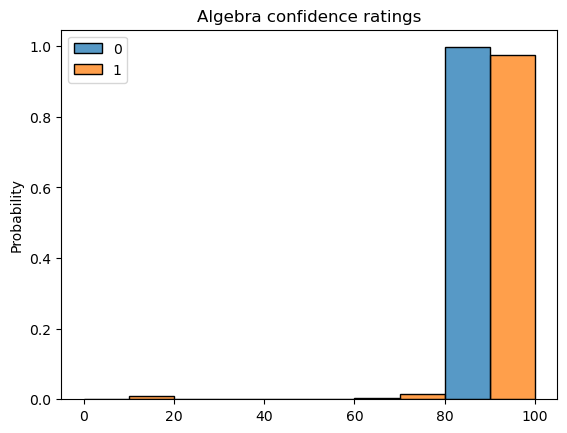

(array([  0,  50,  66,  67,  70,  75,  80,  90,  95,  99, 100]), array([  1,   1,   1,   2,   3,   7,   9,  34,  14,   2, 197]))
(array([  0,  50,  60,  65,  66,  70,  75,  80,  85,  90,  95,  98,  99,
       100]), array([  4,   1,   6,   2,   1,   9,  12,  36,   2,  48,  25,   1,   6,
       343]))
(array([ -1,   0,  50,  60,  65,  66,  67,  70,  75,  80,  85,  90,  95,
        98,  99, 100]), array([  1,   5,   2,   6,   2,   2,   2,  12,  19,  45,   2,  82,  39,
         1,   8, 540]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


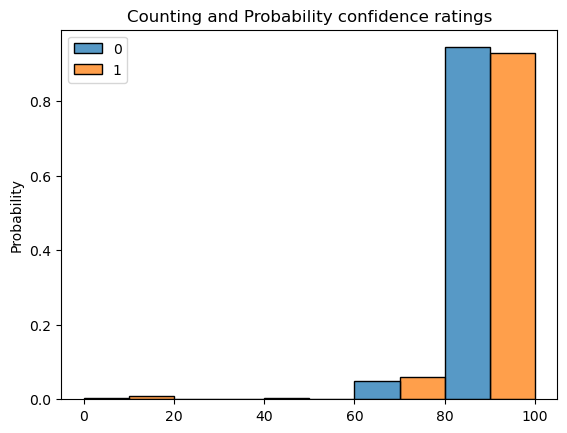

(array([ 75,  80,  90,  95,  97, 100]), array([  2,   4,  25,  21,   1, 164]))
(array([  0,  50,  60,  70,  75,  80,  90,  95,  98,  99, 100]), array([  4,   6,   4,   5,   7,  22,  93,  48,   1,   8, 452]))
(array([  0,  50,  60,  70,  75,  80,  90,  95,  97,  98,  99, 100]), array([  4,   6,   4,   5,   9,  26, 118,  69,   1,   1,   8, 616]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


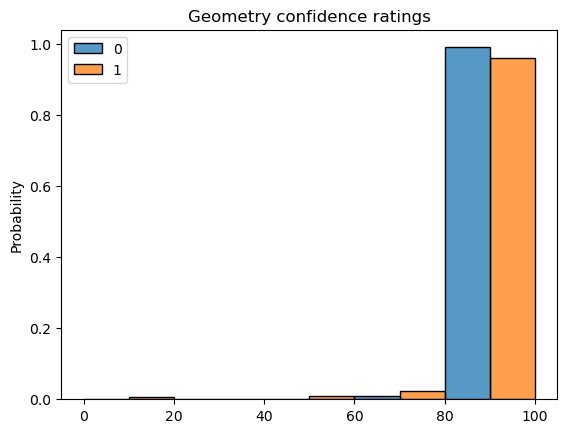

(array([ 75,  80,  90,  95,  97,  98,  99, 100]), array([  2,   6,  25,  14,   2,   4,   9, 224]))
(array([  0,  50,  60,  66,  70,  75,  80,  85,  90,  95,  96,  98,  99,
       100]), array([ 11,   8,   3,   1,   2,  11,  44,   3, 112,  83,   1,   2,  19,
       705]))
(array([ -1,   0,  50,  60,  66,  70,  75,  80,  85,  90,  95,  96,  97,
        98,  99, 100]), array([  1,  11,   8,   3,   1,   2,  13,  50,   3, 137,  97,   1,   2,
         6,  28, 929]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


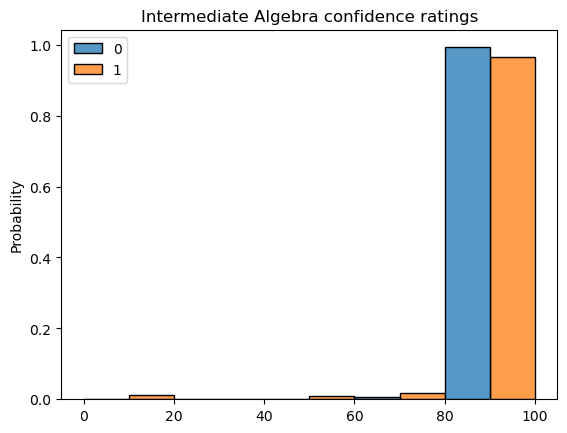

(array([ 75,  80,  85,  90,  95,  96,  98,  99, 100]), array([  1,  10,   1,  36,  18,   1,   3,  14, 258]))
(array([  0,  50,  70,  75,  78,  80,  85,  90,  95,  96,  97,  98,  99,
       100]), array([  6,   2,   2,   1,   1,  25,   2,  51,  41,   1,   1,   4,  13,
       374]))
(array([  0,  50,  70,  75,  78,  80,  85,  90,  95,  96,  97,  98,  99,
       100]), array([  6,   2,   2,   2,   1,  35,   3,  87,  59,   2,   1,   7,  27,
       632]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


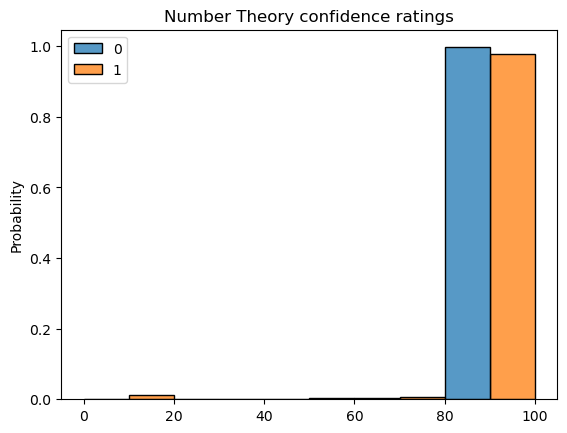

(array([ 75,  80,  85,  90,  95,  97,  98,  99, 100]), array([  2,  14,   3,  58,  40,   2,   5,  15, 659]))
(array([  0,  50,  60,  66,  75,  80,  85,  90,  92,  95,  97,  98,  99,
       100]), array([  2,   2,   2,   1,   3,  15,   1,  28,   1,  25,   1,   3,   4,
       315]))
(array([ -1,   0,  50,  60,  66,  75,  80,  85,  90,  92,  95,  97,  98,
        99, 100]), array([  1,   2,   2,   2,   1,   5,  29,   4,  86,   1,  65,   3,   8,
        19, 974]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


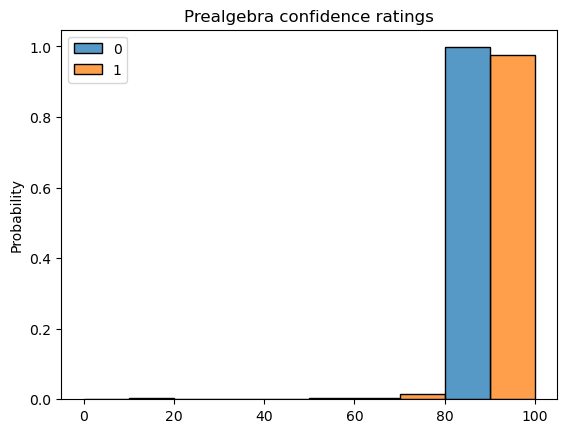

(array([  0,  60,  70,  80,  90,  95,  99, 100]), array([  1,   1,   1,   3,  25,   9,   4, 175]))
(array([  0,  50,  60,  65,  66,  67,  70,  75,  76,  80,  90,  95,  97,
        98,  99, 100]), array([  4,   5,   3,   2,   1,   1,   1,   4,   1,  21,  68,  31,   2,
         1,   7, 372]))
(array([  0,  50,  60,  65,  66,  67,  70,  75,  76,  80,  90,  95,  97,
        98,  99, 100]), array([  5,   5,   4,   2,   1,   1,   2,   4,   1,  24,  93,  40,   2,
         1,  11, 547]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


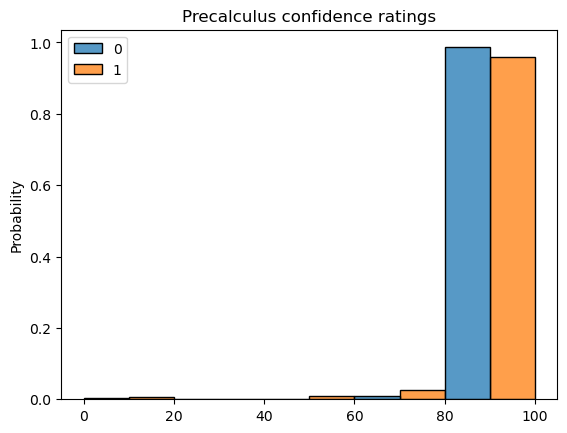

(array([  0,   5,  50,  60,  66,  70,  75,  80,  85,  90,  95,  98,  99,
       100]), array([  11,    1,    4,   47,    2,   30,   73,  144,    1,  291,  242,
          1,   40, 7712]))
(array([  0,  60,  62,  65,  66,  67,  70,  75,  80,  85,  90,  95,  97,
        98,  99, 100]), array([   4,   17,    1,    1,    1,    2,   42,   87,  249,   20,  382,
        301,    4,   10,   51, 5172]))
(array([  0,   5,  50,  60,  62,  65,  66,  67,  70,  75,  80,  85,  90,
        95,  97,  98,  99, 100]), array([   15,     1,     4,    64,     1,     1,     3,     2,    72,
         160,   393,    21,   673,   543,     4,    11,    91, 12884]))


/lfs/hyperturing1/0/kaif/miniforge/envs/sc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


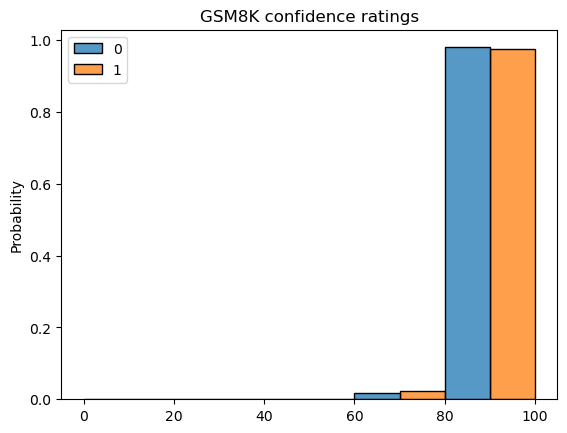

In [86]:
# plot the confidence predictions against grades
import matplotlib.pyplot as plt
import seaborn as sns

num_malformed_confidence_predictions = 0


def get_confidence(confidence_prediction):
    # get the confidence from the confidence prediction
    # if not found return -1
    try:
        confidence_part = confidence_prediction.outputs[0].text.split('\n')[0]
        if '%' in confidence_part:
            return int(confidence_part.split('%')[0])
        else:
            return int(confidence_part)
    except:
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        return -1


def get_rating(confidence_prediction):
    # get the rating from the confidence prediction
    # if not found return -1
    # int(o.outputs[0].text.split('Rating: ')[1])
    try:
        rating_part = confidence_prediction.outputs[0].text.split('Rating: ')[1]
        return int(rating_part[0])
    except:
        global num_malformed_confidence_predictions
        num_malformed_confidence_predictions += 1
        # print(confidence_prediction.outputs[0].text)
        # raise ValueError
        return -1


# one plot for each dataset
for dataset, data in confidence_predictions.items():
    confidences = [get_confidence(o) for o in data]
    # distribution of confidence ratings
    # sns.histplot(confidences)
    # plt.title(f"{dataset} confidence ratings")
    # plt.show()
    # plot the confidence ratings against the grades
    correct = [c for g, c in zip(grades[dataset], confidences) if c != -1 and g]
    incorrect = [c for g, c in zip(grades[dataset], confidences) if c != -1 and not g]
    print(np.unique(correct, return_counts=True))
    print(np.unique(incorrect, return_counts=True))
    print(np.unique(confidences, return_counts=True))
    # plot categorical distribution of rating conditioned on correctness
    # x axis is categorical, y axis is density
    # two histograms should be interleaved, not stacked
    sns.histplot([correct, incorrect], stat='probability', common_norm=False, bins=5, multiple='dodge', legend=True)

    plt.title(f"{dataset} confidence ratings")
    plt.show()


In [14]:
# save the predictions
# for dataset, outputs in predictions.items():
#     with open(save_dir / f"{dataset.replace(' ', '-')}_{MODEL_MAP[model_name]}_predictions.pkl", "wb") as f:
#         pickle.dump(outputs, f)

In [5]:
def generate(prompts, model, sampling_params, chat_mode=False):
    outputs = llm.generate(prompts, sampling_params)
    if chat_mode:
        return [prompt + o.outputs[0].text for prompt, o in zip(prompts, outputs)]
    else:
        return [o.outputs[0].text for o in outputs]

In [7]:
prompts = ["""A board game spinner is divided into three parts labeled $A$, $B$  and $C$.
The probability of the spinner landing on $A$ is $\\frac{1}{3}$ and the
probability of the spinner landing on $B$ is $\\frac{5}{12}$.  What is
the probability of the spinner landing on $C$? Express your answer as a
common fraction. Write your final answer as "\\boxed{...}".

Solution:
"""]
# Solution: The spinner is guaranteed to land on exactly one of the three
# regions, so we know that the sum of the probabilities of it landing in
# each region will be 1. If we let the probability of it landing in region
# $C$ be $x$, we then have the equation $1 = \\frac{5}{12}+\\frac{1}{3}+x$,
# from which we have $x=\\boxed{\\frac{1}{4}}$.

# Above is a question and correct solution. What is a mistake someone might make when solving the problem?

# Mistake:"""]
outputs = generate(prompts, llm, sampling_params, chat_mode=True)
print(outputs[0])

Processed prompts: 100%|████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.34s/it]

A board game spinner is divided into three parts labeled $A$, $B$  and $C$.
The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the
probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is
the probability of the spinner landing on $C$? Express your answer as a
common fraction. Write your final answer as "\boxed{...}".

Solution:
We want to find the probability of the spinner landing on $C$, which means that it must land on $A$ or $B$ and not on $C$. We can find this by using the formula for conditional probability:

P(C) = P(C|A) \* P(A) + P(C|B) \* P(B)

We know that P(A) = $\frac{1}{3}$ and P(B) = $\frac{5}{12}$, so we need to find P(C|A) and P(C|B).

P(C|A) means the probability of the spinner landing on $C$ given that it landed on $A$. To find this, we need to know the probability of the spinner landing on $B$ or $C$ given that it landed on $A$. However, we don't have that information, so we will assume that the probabilities are equal. That is, P(B|A) =

In [14]:
prompts2 = [o + """

Are you sure this is correct?
""" for o in outputs]
outputs2 = generate(prompts2, llm, sampling_params, chat_mode=True)
print(outputs2[0])

Processed prompts: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]

A board game spinner is divided into three parts labeled $A$, $B$  and $C$.
The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the
probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is
the probability of the spinner landing on $C$? Express your answer as a
common fraction. Write your final answer as "\boxed{...}".

Solution:
We want to find the probability of the spinner landing on $C$, which means that it must land on $A$ or $B$ and not on $C$. We can find this by using the formula for conditional probability:

P(C) = P(C|A) \* P(A) + P(C|B) \* P(B)

We know that P(A) = $\frac{1}{3}$ and P(B) = $\frac{5}{12}$, so we need to find P(C|A) and P(C|B).

P(C|A) means the probability of the spinner landing on $C$ given that it landed on $A$. To find this, we need to know the probability of the spinner landing on $B$ or $C$ given that it landed on $A$. However, we don't have that information, so we will assume that the probabilities are equal. That is, P(B|A) =

In [27]:
prompts2 = [o + """

Now construct a response that makes this mistake followed 
by a teacher explaining the mistake made. Begin with "Incorrect Solution:" 
and the teacher corrections with "Teacher Correction:".

Incorrect Solution: """ for o in outputs]
outputs2 = generate(prompts2, llm, sampling_params, chat_mode=True)
print(outputs2[0])

Processed prompts: 100%|████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.87s/it]

A board game spinner is divided into three parts labeled $A$, $B$  and $C$.
The probability of the spinner landing on $A$ is $\frac{1}{3}$ and the
probability of the spinner landing on $B$ is $\frac{5}{12}$.  What is
the probability of the spinner landing on $C$? Express your answer as a
common fraction.

Solution: The spinner is guaranteed to land on exactly one of the three
regions, so we know that the sum of the probabilities of it landing in
each region will be 1. If we let the probability of it landing in region
$C$ be $x$, we then have the equation $1 = \frac{5}{12}+\frac{1}{3}+x$,
from which we have $x=\boxed{\frac{1}{4}}$.

Above is a question and correct solution. What is a mistake someone might make when solving the problem?

Mistake: One possible mistake is assuming that the probabilities of the spinner landing on each of the three regions must be equal, and therefore setting $x=\frac{1}{3}$. This is incorrect, as the given probabilities for $A$ and $B$ already show that the